In [32]:
import os
import time
import imageio
import json
import glob
from datetime import datetime, timedelta

import folium 
import geojsoncontour
import numpy as np

from netCDF4 import Dataset as NetCDFFile
from wrf import getvar, interplevel, to_np, latlon_coords

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
nc_file = NetCDFFile('../wrf_output')
time_size = nc_file.dimensions['Time'].size

In [15]:
height = getvar(nc_file, 'height', timeidx=1)
u_all = getvar(nc_file, 'ua', timeidx=1)
v_all = getvar(nc_file, 'va', timeidx=1)

u = interplevel(u_all, height, 150)
v = interplevel(v_all, height, 150)

(lats, lons) = latlon_coords(u)

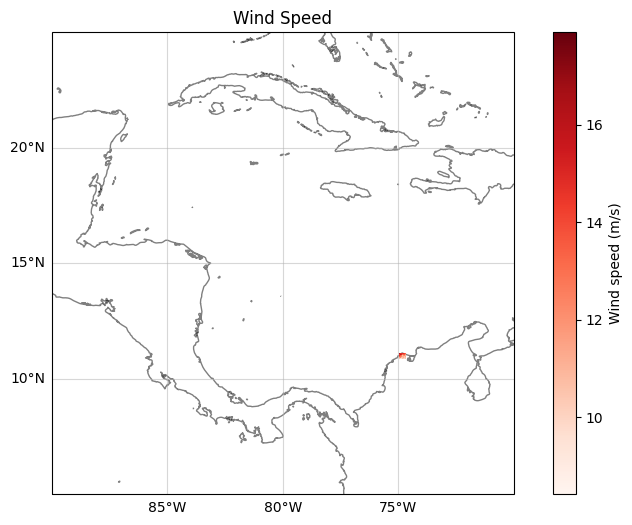

In [65]:
fig = plt.figure(figsize=(10,6))

cmap = plt.get_cmap('Reds')
crs = ccrs.PlateCarree()

ax = fig.add_subplot(111, facecolor='None', projection=crs)
ax.coastlines(resolution='10m', alpha=0.5)

colormesh = ax.pcolormesh(lons, lats, np.sqrt(u**2+v**2), cmap=cmap)
cbar = fig.colorbar(colormesh)
cbar.ax.set_ylabel('Wind speed (m/s)')

lat_min = 5
lat_max = 25
lon_min = -90
lon_max = -70


gl = ax.gridlines(crs=crs, draw_labels=True, alpha=0.5)
gl.top_labels = None
gl.right_labels = None
xgrid = np.arange(lon_min-10, lon_max+10, 5.)
ygrid = np.arange(lat_min-10, lat_max+10, 5.)
gl.xlocator = mticker.FixedLocator(xgrid.tolist())
gl.ylocator = mticker.FixedLocator(ygrid.tolist())
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

plt.xlim((lon_min,lon_max))
plt.ylim((lat_min, lat_max))
plt.title('Wind Speed')

plt.show();

In [36]:
lat_min

<xarray.DataArray 'XLAT' ()>
array(10.8528, dtype=float32)
Coordinates:
    XTIME    float32 180.0
    Time     datetime64[ns] 2022-03-29T21:00:00
    level    int64 150

In [37]:
lat_max

<xarray.DataArray 'XLAT' ()>
array(11.1092, dtype=float32)
Coordinates:
    XTIME    float32 180.0
    Time     datetime64[ns] 2022-03-29T21:00:00
    level    int64 150

In [38]:
lon_min

<xarray.DataArray 'XLONG' ()>
array(-74.96463, dtype=float32)
Coordinates:
    XTIME    float32 180.0
    Time     datetime64[ns] 2022-03-29T21:00:00
    level    int64 150

In [39]:
lon_max

<xarray.DataArray 'XLONG' ()>
array(-74.679375, dtype=float32)
Coordinates:
    XTIME    float32 180.0
    Time     datetime64[ns] 2022-03-29T21:00:00
    level    int64 150

In [50]:
def get_data(nc_file: NetCDFFile, timeidx:int):
    dx = 150
    height = getvar(nc_file, 'height', timeidx=timeidx)

    u_all = getvar(nc_file, 'ua', timeidx=timeidx)
    v_all = getvar(nc_file, 'va', timeidx=timeidx)
    w_all = getvar(nc_file, 'wa', timeidx=timeidx)
    T_all = getvar(nc_file, 'tc', timeidx=timeidx)
    P_all = getvar(nc_file, 'pressure', timeidx=timeidx)

    P = interplevel(P_all, height, dx)
    T = interplevel(T_all, height, dx)
    u = interplevel(u_all, height, dx)
    v = interplevel(v_all, height, dx)
    w = interplevel(w_all, height, dx)
    
    data = {
        'wind': ('Wind velocity (m/s)', np.sqrt(u ** 2 + v ** 2 + w ** 2)),
        'temp': ('Temperature (C)', T),
        'uwind': ('U Wind velocity (m/s)', u),
        'vwind': ('V Wind velocity (m/s)', v),
        'press': ('Pressure (hPa)', P)
    }

    return data


def get_folium(nc_file: NetCDFFile, timeidx: int, nc_var: str, start_date: datetime):
    data = get_data(nc_file, timeidx)
    
    (caption, variable) = data[nc_var]
    
    (lats, lons) = latlon_coords(variable)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    contour = ax.contourf(lons, lats, variable, cmap=plt.cm.jet)
    cbar = fig.colorbar(contour)

    gj = json.loads(geojsoncontour.contourf_to_geojson(contourf=contour, ndigits=6, unit='m'))

    folium_map = folium.Map(
        location=[lats.mean(), lons.mean()],
        tiles='Cartodb Positron',
        zoom_start=12,
        zoom_control=False,
        scrollWheelZoom=False,
        dragging=False
    )

    folium.GeoJson(
        gj,
        style_function=lambda x: {
            'color': x['properties']['stroke'],
            'weight': x['properties']['stroke-width'],
            'fillColor': x['properties']['fill'],
            'opacity': 0.3,
        },
        name='geojson'
    ).add_to(folium_map)

    colormap = cm.LinearColormap(
        colors=['darkblue', 'blue', 'cyan', 'green', 'greenyellow', 'yellow', 'orange', 'red', 'darkred'],
        index=np.array(cbar.values), vmin=cbar.values[0],
        vmax=cbar.values[len(cbar.values) - 1],
        caption=caption
    )

    folium_map.add_child(colormap)

    date = start_date + timedelta(hours=timeidx * 3) - timedelta(hours=5)
    folium_map.get_root().html.add_child(folium.Element('<span style="position:fixed;z-index:999;font-size:12px;margin:4px">{}</span>'.format(date)))

    return folium_map


def get_image(timeidx: int, nc_var: str, start_date: datetime, driver):
    f_map = get_folium(nc_file, timeidx, nc_var, start_date)

    html_file = f"{nc_var}_{timeidx}.html"
    png_file = f"{nc_var}_{timeidx}.png"

    f_map.save(html_file)

    driver.get(f"file://{os.getcwd()}/{html_file}")
    wait_for_ajax(driver)
    driver.save_screenshot(png_file)

    img = imageio.imread(png_file)

    os.remove(html_file)
    os.remove(png_file)

    return img

def wait_for_ajax(driver):
    wait = WebDriverWait(driver, 15)
    try:
        wait.until(lambda driver: driver.execute_script('return jQuery.active') == 0)
        wait.until(lambda driver: driver.execute_script('return document.readyState') == 'complete')
    except Exception as e:
        pass

In [49]:
nc_var = 'temp'
start_date = datetime.strptime("2022-03-26 18", '%Y-%m-%d %H')

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome(options=options)
driver.set_window_size(600, 600)

results = [get_image(timeidx, nc_var, start_date, driver) for timeidx in range(time_size)]

imageio.mimwrite(f"{nc_var}_test.gif", results, fps=1)

driver.quit();